# Mask R-CNN for detecting car damage

### Table of content

1. Use case description
2. Data
3. Model
4. Training
5. Accuracy
6. Results

### Use case description

Mask R-CNN is an instance segmentation where each individual object is separated and identified; this approach incldues finding the bounding boxes of each object and assignment of the unique label to the identified objects [1]. The model is trained on COCO dataset which is a large-scale object detection, segmentation, and captioning dataset including 80 categories, 1,500,000 object instances, and over 330,000 images [2]. 

The goal of this notebook is to explore the Mask R-CNN model to detect car damage areas. The underlying rationale for this model development resides in its potential utility within the insurance industry, wherein expedited claims processing can be facilitated through the integration of user-uploaded images, thereby enabling damage assessment. Additionally, the model exhibits relevance to financial institutions, particularly when engaged in the underwriting of automotive loans, with a specific focus on pre-owned vehicles.

##### Set up the environment

Import all the necessary packages and set the plotting preferences.

In [1]:
from mrcnn import utils, visualize, model as modellib

import os
import json
import numpy as np
from PIL import Image

import skimage

from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

### Data

The dataset was retrived from Matterport Mask R-CNN repository which is highly recommended to use by the original author. This sample consists of 66 images, 50 of which are in the train set and 16 in the validation. Each image was further annotated using VGG Image Annotator tool (v 1.0.6) that lets us create custom annotations for any dataset. 

The dataset's location is stored in Priya Dwivedi's GitHub repository and was retrieved using [download-directory](https://download-directory.github.io/) website to retrieve a subdirectory storing the images and annotations. The following steps are used for the data preparation:

- Showing an example of a damaged car
- Loading and preprocessing the dataset using a custom `Dataset` class
- Loading and preprocessing the annotations

Random image: customImages/train/image8.jpg


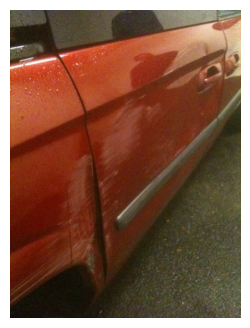

In [2]:
# show an example of image 

# select a random image
img = 'customImages/train/' + np.random.choice(os.listdir('customImages/train'), 1)[0]

# print selection
print(f'Random image: {img}')

# plot image
plt.figure(figsize=(7, 4))      # set figure size
plt.imshow(Image.open(img))     # show image
plt.axis('off')                 # remove axis
plt.grid(False)                 # remove grid
plt.show()                      # show image

#### Load data 

We will use the predefined functionality given by the [Mask R-CNN](https://github.com/matterport/Mask_RCNN) repository. Specifically, we will use their data loading class - `Dataset` from the `utils` file which consists of the following fragment:

```
# load images and annotations
class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("damage", 1, "damage")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations1.values()) # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
            "damage", ## for a single class just add the name here
            image_id=a['filename'], # use file name as a unique image id
            path=image_path,
            width=width, height=height,
            polygons=polygons)
```

In [3]:
import custom 

# Root directory of the project
ROOT_DIR = os.getcwd()

# configure paths
config = custom.CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "customImages")         # join paths
print(CUSTOM_DIR)                                           # show paths


# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = custom.CustomDataset()
dataset.load_custom(CUSTOM_DIR, "train")

# Must call before using the dataset
dataset.prepare()                                           # prepare dataset

print("Image Count: {}".format(len(dataset.image_ids)))     # show image count
print("Class Count: {}".format(dataset.num_classes))        # show class count

# iterate over classes and show info
for i, info in enumerate(dataset.class_info):       
    print("{:3}. {:50}".format(i, info['name']))

c:\Users\dinar\Desktop\university\computer_vision\rcnn_car_damage\customImages
Image Count: 49
Class Count: 2
  0. BG                                                
  1. damage                                            


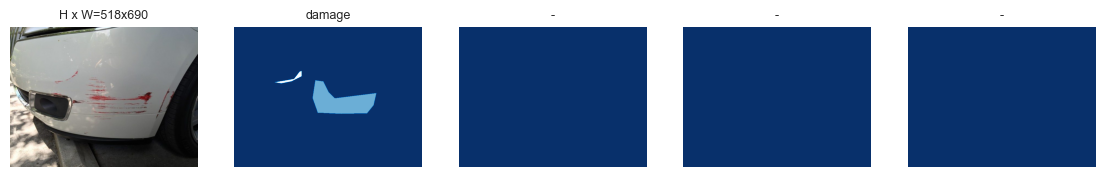

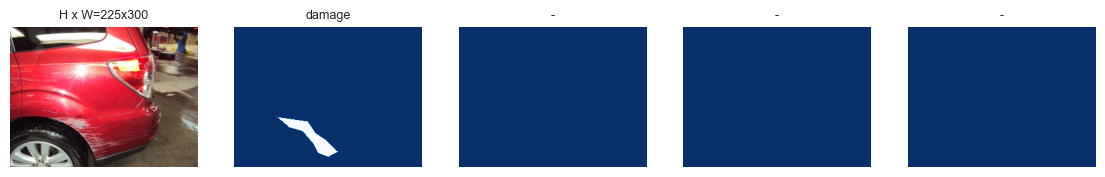

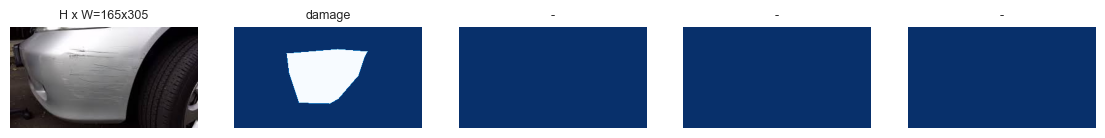

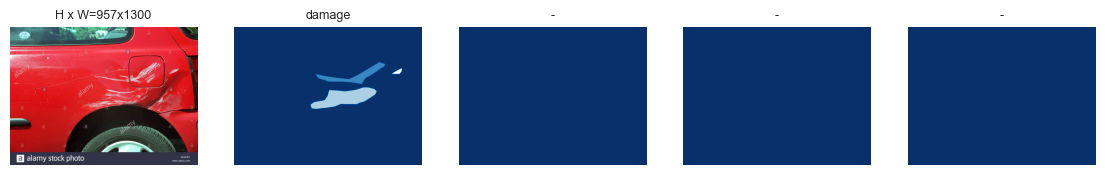

In [4]:
# display images
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)

# iterate over images
for image_id in image_ids:
    image = dataset.load_image(image_id)                # load image
    mask, class_ids = dataset.load_mask(image_id)       # load annotations
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)    # visualize both image and annotations

image_id  32 c:\Users\dinar\Desktop\university\computer_vision\rcnn_car_damage\customImages\train\image19.jpeg


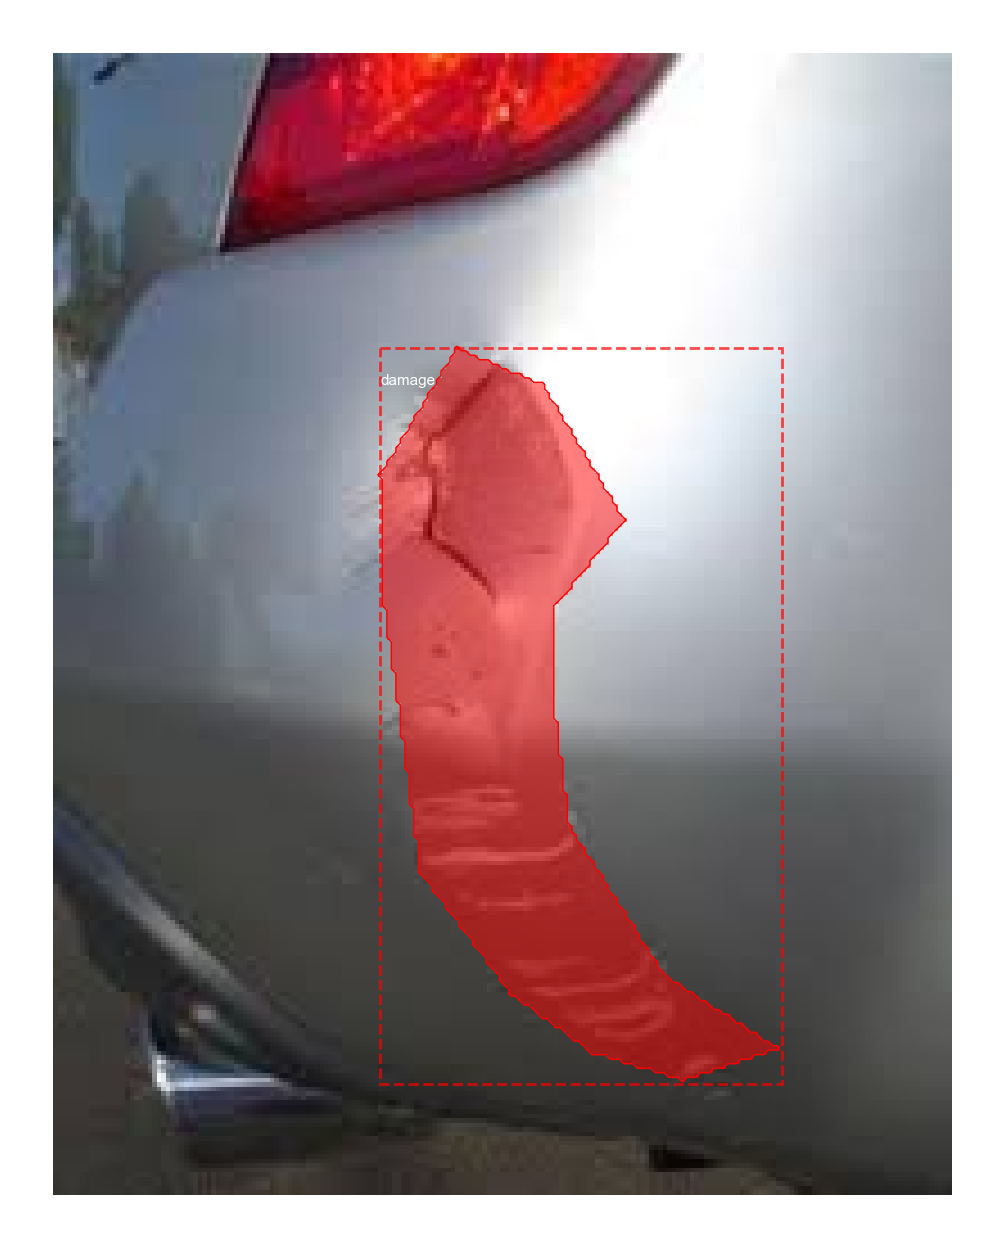

In [17]:
import random 

# Get BB and details of random image
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Model

Modeling part is done by calling Mask R-CNN's `MaskRCNN` class in the `maskrcnn.model` file. 

In [5]:
# import packages
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import tensorflow as tf

In [7]:
# # Device to load the neural network on.
# # Useful if you're training a model on the same 
# # machine, in which case use CPU and leave the
# # GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# # Inspect the model in training or inference modes
# # values: 'inference' or 'training'
# # TODO: code for 'training' test mode not ready yet
# TEST_MODE = "tra"

There were too many bugs in this implementation. The things that helped me was to perform the following steps suggested by @mayurmahurkar on [this thread](https://github.com/matterport/Mask_RCNN/issues/1070), specifically:

```
1. Upgrade the scripts by using the following line on the root folder:

 tf_upgrade_v2 --intree Mask_RCNN --inplace --reportfile report.txt

This will automatically update the existing code to TF2. You will also get a list of changes made in report.txt

2. Replace the following line:

mrcnn_bbox = layers.Reshape((-1, num_classes, 4), name="mrcnn_bbox")(x) 
with this this if-else code block:

if s[1]==None:
  mrcnn_bbox = layers.Reshape((-1, num_classes, 4), name="mrcnn_bbox")(x)
 else:
  mrcnn_bbox = layers.Reshape((s[1], num_classes, 4), name="mrcnn_bbox")(x)
3. Change the following line:

indices = tf.stack([tf.range(probs.shape[0]), class_ids], axis=1) 
with this line:

indices = tf.stack([tf.range(tf.shape(probs)[0]), class_ids], axis = 1)

4. Now, you need to replace:

  from keras import saving
with:

from tensorflow.python.keras import saving 
then you will also want to replace the lines in both if and else block:

saving.load_weights_from_hdf5_group(f, layers) 
and so on with the follwoing lines, inside if and else block respectively:

saving.hdf5_format.load_weights_from_hdf5_group_by_name(f, layers)

saving.hdf5_format.load_weights_from_hdf5_group(f, layers)
```

Afterward, follow [this thread on StackOverflow](https://stackoverflow.com/questions/65298869/attributeerror-module-tensorflow-api-v2-sets-has-no-attribute-set-intersect) to add compatibility with tensorflow's older packages. 

In [8]:
from importlib import reload 
reload(modellib)

# # Device to load the neural network on.
# # Useful if you're training a model on the same 
# # machine, in which case use CPU and leave the
# # GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR,
                              config=config)

# Train

#### Downloading weights

The model can be ran using two different weights:

- Using pretrained COCO weights
- Using custom weights after training

To get the pretrained weights, we need to download them from COCO website which [can be found here](https://github.com/matterport/Mask_RCNN/releases). The code below sets up the path and download for the weights if they're not defined already. Alternatively, it reads the existing ones.

In [9]:
# MS COCO Dataset
import coco
config = coco.CocoConfig()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

In [10]:
# configure 
config = custom.CustomConfig()
config.display()

# set logs dir
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# create the model
model = modellib.MaskRCNN(mode='training', config=config, model_dir=DEFAULT_LOGS_DIR)

# set weights
weights = 'mask_rcnn_coco.h5'
print('Weights path:', weights)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [11]:
custom.train(model, 'customImages/', config)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: c:\Users\dinar\Desktop\university\computer_vision\rcnn_car_damage\logs\damage20230926T1347\mask_rcnn_damage_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistribu

c:\Users\dinar\miniconda3\envs\pneumonia\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100/100 [==============================] - 4839s 48s/step - batch: 49.5000 - size: 2.0000 - loss: 16.4469 - rpn_class_loss: 1.0986 - rpn_bbox_loss: 12.0979 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 3.2019 - mrcnn_mask_loss: 0.0259 - val_loss: 8.4672 - val_rpn_class_loss: 0.2427 - val_rpn_bbox_loss: 5.9758 - val_mrcnn_class_loss: 0.0053 - val_mrcnn_bbox_loss: 2.2415 - val_mrcnn_mask_loss: 0.0018
Epoch 2/10
100/100 [==============================] - 4559s 46s/step - batch: 49.5000 - size: 2.0000 - loss: 10.3807 - rpn_class_loss: 0.3726 - rpn_bbox_loss: 7.3117 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 2.6601 - mrcnn_mask_loss: 0.0013 - val_loss: 8.5306 - val_rpn_class_loss: 0.2122 - val_rpn_bbox_loss: 6.7839 - val_mrcnn_class_loss: 0.0022 - val_mrcnn_bbox_loss: 1.5312 - val_mrcnn_mask_loss: 0.0011
Epoch 3/10
100/100 [==============================] - 4564s 46s/step - batch: 49.5000 - size: 2.0000 - loss: 8.4981 - rpn_class_loss: 0.2520 - rpn_bbox_loss: 5.6485 - mrcnn_class_loss: 0

# Results

In [61]:
import sys

# Root directory of the project
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)  # To find local version of the library

# Directory of logs 
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained model
custom_WEIGHTS_PATH = 'mask_rcnn_damage_0100.h5'

# Configurations
config = custom.CustomConfig()
dataset_DIR = os.path.join(ROOT_DIR, "")
dataset_DIR

'c:\\Users\\dinar\\Desktop\\university\\computer_vision\\rcnn_car_damage\\'

In [62]:
# Load dataset
dataset = custom.CustomDataset()
dataset.load_custom('customImages', "train")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 49
Class Count: 2
  0. BG                                                
  1. damage                                            


image_id  25 customImages\train\image40.jpeg
image                    shape: (194, 259, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (194, 259, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   60.00000  max:  230.00000  int32


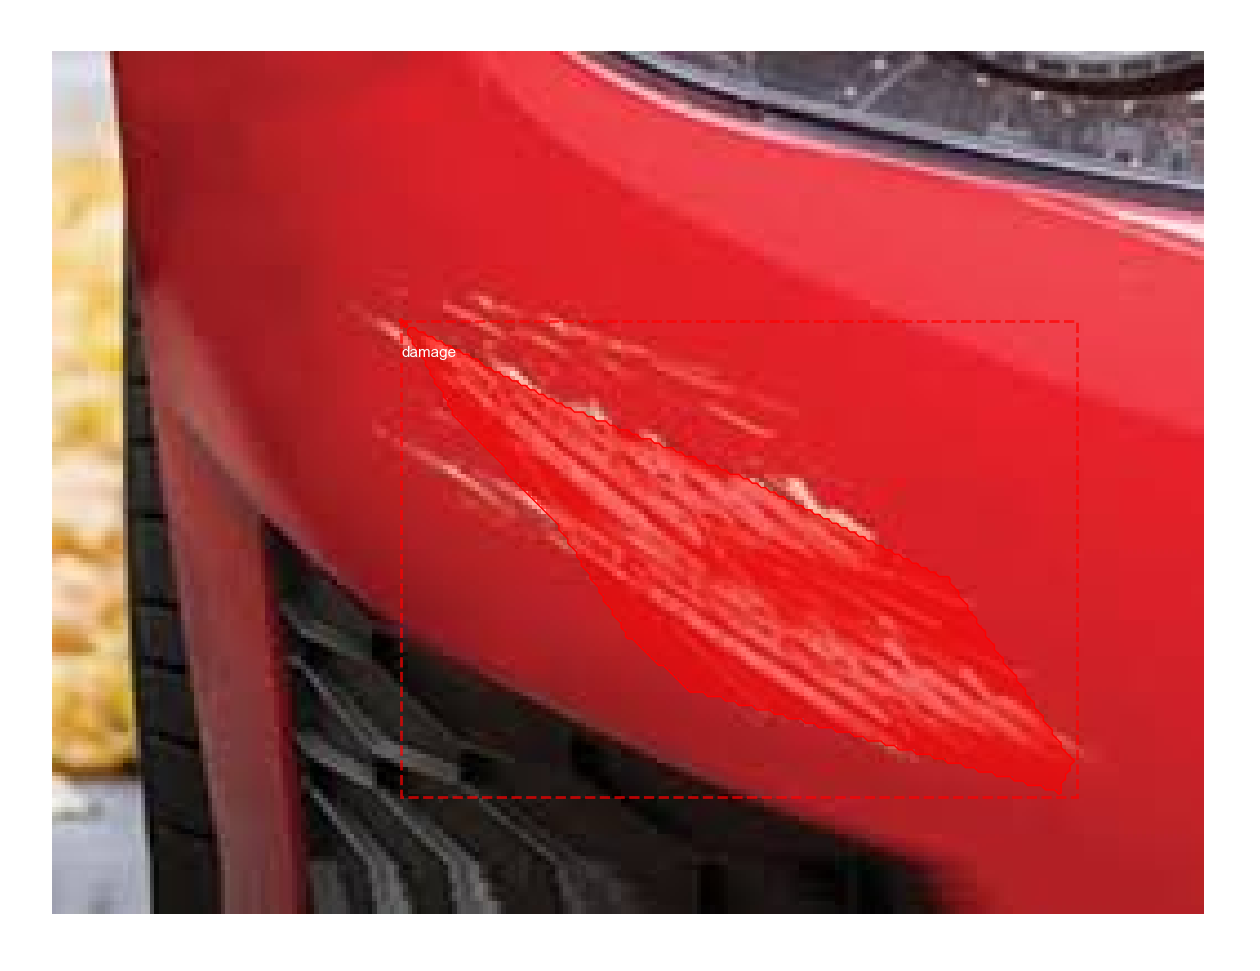

In [64]:
# Get BB and details of random image
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [67]:
# Use the model as inference mode.
config = custom.CustomConfig()
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on
DEVICE = "/cpu:0"  # /gpu:0

# Inspect the model in inference mode
TEST_MODE = "inference"


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [69]:
# Create model in inference mode
import tensorflow as tf
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

Loading weights  mask_rcnn_damage_0100.h5


In [71]:
dataset = custom.CustomDataset()
dataset.load_custom('customImages','val')
dataset.prepare()
print('Images: {}\nclasses: {}'.format(len(dataset.image_ids), dataset.class_names))

Images: 15
classes: ['BG', 'damage']


image ID: damage.image79.jpg (2) customImages\val\image79.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Starting point (x, y): (325, 364)
Height: 218 	Width: 505


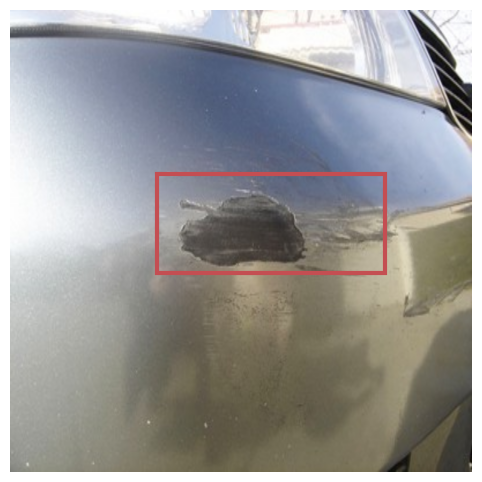

In [155]:
import cv2
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox

image_map = {v:k[7:] for k, v in dataset.image_from_source_map.items()}
image_id = 2
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
                   
# Run object detection
results = model.detect([image], verbose=1)

# get coordinates to plot predicted box
y1, y2, x1, x2 = gt_bbox[0][0], gt_bbox[0][2], gt_bbox[0][1], gt_bbox[0][-1]

# find the starting location
xy = (x1, y1)
print('Starting point (x, y):', xy)

# get height and width
height, width = y2 - y1, x2 - x1
print('Height:', height, '\tWidth:', width)

# create a rectangle to add as a patch
rect = Rectangle(xy, width, height, edgecolor='r', fill=False, linewidth=3)

# get the image
image = cv2.imread('customImages/val/' + image_map[image_id])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(image)            # show image
ax.add_patch(rect)          # add rectangle
ax.axis('off')              # remove axis
ax.grid('off')              # remove grid
plt.show()

image ID: damage.image62.jpg (13) customImages\val\image62.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Starting point (x, y): (241, 543)
Height: 94 	Width: 435


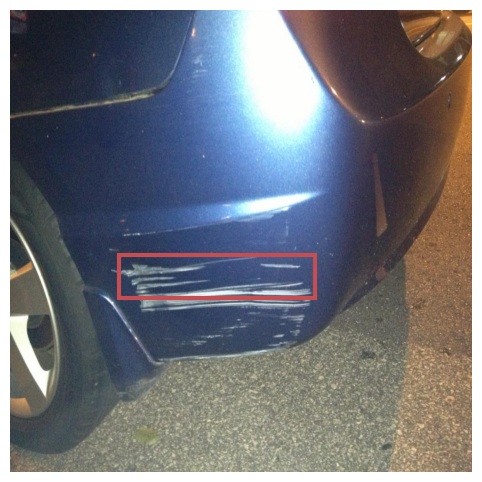

In [160]:
import cv2
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox

image_map = {v:k[7:] for k, v in dataset.image_from_source_map.items()}
image_id = 13
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
                   
# Run object detection
results = model.detect([image], verbose=1)

# get coordinates to plot predicted box
y1, y2, x1, x2 = gt_bbox[0][0], gt_bbox[0][2], gt_bbox[0][1], gt_bbox[0][-1]

# find the starting location
xy = (x1, y1)
print('Starting point (x, y):', xy)

# get height and width
height, width = y2 - y1, x2 - x1
print('Height:', height, '\tWidth:', width)

# create a rectangle to add as a patch
rect = Rectangle(xy, width, height, edgecolor='r', fill=False, linewidth=3)

# get the image
image = cv2.imread('customImages/val/' + image_map[image_id])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(image)            # show image
ax.add_patch(rect)          # add rectangle
ax.axis('off')              # remove axis
ax.grid('off')              # remove grid
plt.show()

#### References

[1] He, K., Gkioxari, G., Dollár, P., & Girshick, R. (2017). Mask r-cnn. In *Proceedings of the IEEE international conference on computer vision* (pp. 2961-2969).

[2] Lin, T. Y., Maire, M., Belongie, S., Hays, J., Perona, P., Ramanan, D., ... & Zitnick, C. L. (2014). Microsoft coco: Common objects in context. In *Computer Vision–ECCV 2014: 13th European Conference, Zurich, Switzerland, September 6-12, 2014, Proceedings, Part V 13* (pp. 740-755). Springer International Publishing.